## Imports

In [1]:
# data analysis stack
import pandas as pd
import numpy as np

# data visualization stack
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler

# date stack
import datetime

# machine learning stack - sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import r2_score

# FB model for timeseries predictions
from prophet import Prophet

# statsmodels
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARIMA,ARIMAResults,ARMA,ARMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.ar_model import ar_select_order
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf
from pmdarima.arima import auto_arima

# Set figure size 
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.linestyle'] = '--'

# miscellaneous
import warnings
warnings.filterwarnings("ignore")


##  Define the Business Goal - create a short-term temperature forecast.

- Get and clean temperature data from www.ecad.eu.

- Build a baseline model modelling trend and seasonality.

- Plot and inspect the different components of a time series.

- Model time dependence of the remainder using an AR model.

- Compare the statistical output of different AR models.

- Test the remainder for stationarity.

- Upload the project to GitHub.

## 1) Get the Data

### 1.1) Load the Data

In [2]:
with open("TG_STAID002759.txt") as f:
          l=f.readlines()

In [3]:
for i in range(10,14):
    print(l[i])

01-06 SOUID: Source identifier

08-15 DATE : Date YYYYMMDD

17-21 TG   : mean temperature in 0.1 &#176;C

23-27 Q_TG : Quality code for TG (0='valid'; 1='suspect'; 9='missing')



In [4]:
df = pd.read_csv('TG_STAID002759.txt', skiprows=19)
df.columns = df.columns.str.strip()

### 1.2) Clean the Data

In [5]:
# converted to a string
df['DATE']=df['DATE'].astype(str)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53507 entries, 0 to 53506
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   SOUID   53507 non-null  int64 
 1   DATE    53507 non-null  object
 2   TG      53507 non-null  int64 
 3   Q_TG    53507 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.6+ MB


In [7]:
#changed to datetime format and reset index
df['DATE']=pd.to_datetime(df['DATE'])
df=df.set_index('DATE')

In [8]:
df

,SOUID,TG,Q_TG
DATE,,,
1876-01-01,127488,22,0
1876-01-02,127488,25,0
1876-01-03,127488,3,0
1876-01-04,127488,-58,0
1876-01-05,127488,-98,0
...,...,...,...
2022-06-26,111448,263,0
2022-06-27,111448,281,0
2022-06-28,111448,214,0


In [9]:
#there were 195 wrong values within the year range of 1945. 
df[df['Q_TG']==9].value_counts()

SOUID   TG     Q_TG
127488  -9999  9       195
dtype: int64

In [10]:
#convert to a standard Celcius format
df['TG']=df['TG']*0.1

In [11]:
df

,SOUID,TG,Q_TG
DATE,,,
1876-01-01,127488,2.2,0
1876-01-02,127488,2.5,0
1876-01-03,127488,0.3,0
1876-01-04,127488,-5.8,0
1876-01-05,127488,-9.8,0
...,...,...,...
2022-06-26,111448,26.3,0
2022-06-27,111448,28.1,0
2022-06-28,111448,21.4,0



- SOUID stands for the source identifier
- DATE is a date in the followinf format(YYYYMMDD)
- TG represents mean temperature in 0.1 &#176;C (-9999=missing value)
- Q_TG is a quality code for TG (0='valid'; 1='suspect'; 9='missing')

In [12]:
df[df.index.year==2022].mean()

SOUID    111448.000000
TG           10.072928
Q_TG          0.000000
dtype: float64

In [13]:
#select 1970-2022 as our data,
df_new=df.loc['1950-01-01':'2022-06-30'].drop(['Q_TG','SOUID'],axis=1)

In [14]:
df_feat=df.loc['2022-06-30':].drop(['Q_TG','SOUID'],axis=1)
df_feat.to_pickle('df_feat.pkl') #  saving fro forcast"

In [15]:
df_train=df_new.loc['1950-01-01':'2021-06-29']
df_test=df_new.loc['2021-06-30':'2022-06-30']

<AxesSubplot:xlabel='DATE'>

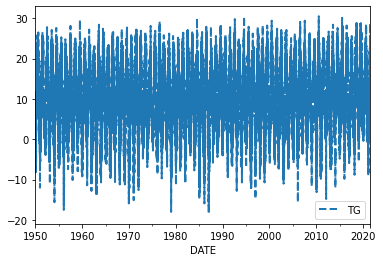

In [16]:
df_train.plot()


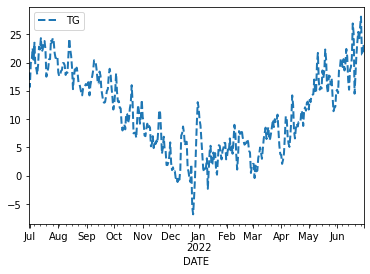

In [17]:
df_test.plot()
df_test.to_pickle('df_test.pkl')


<AxesSubplot:xlabel='DATE'>

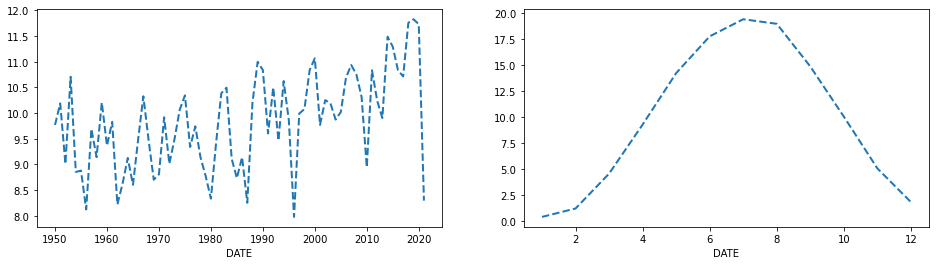

In [18]:
fig,(ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(16, 4)
df_train.groupby(df_train.index.year)['TG'].mean().plot(ax=ax1)
df_train.groupby(df_train.index.month)['TG'].mean().plot(ax=ax2)

<AxesSubplot:xlabel='TG', ylabel='Density'>

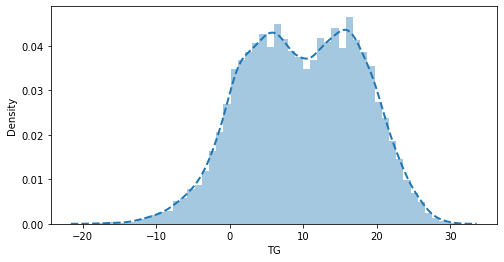

In [19]:
plt.figure(figsize=(8,4))
sns.distplot(df_train["TG"])

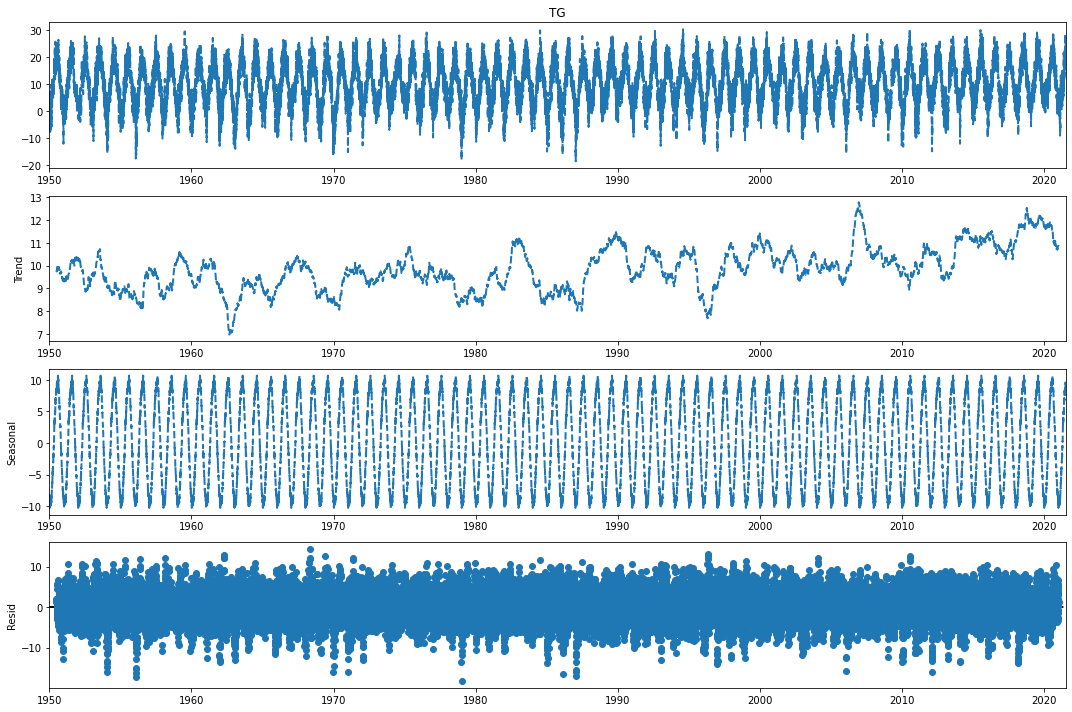

In [20]:
plt.rcParams['figure.figsize'] = (15,10)
decomposition = sm.tsa.seasonal_decompose(df_train['TG'], model='additive',period=365)
fig = decomposition.plot()
plt.show()

In [21]:
## Dickey–Fuller test
def perform_dickey_fuller_test(ts):
    result = adfuller(ts, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\\t%s: %.3f' % (key, value))
perform_dickey_fuller_test(df_train['TG'])

ADF Statistic: -12.562810
p-value: 0.000000
Critical Values:
\t1%: -3.431
\t5%: -2.862
\t10%: -2.567


1) We can see that our statistic value of -12.079368 is less than the value of -3.430739767618574 at t1%. 
- This suggests that we can reject the null hypothesis with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke). 
- Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.(why? the result should show not stationary data..).

2) Let's check the mean and variance of the first and the last three months.

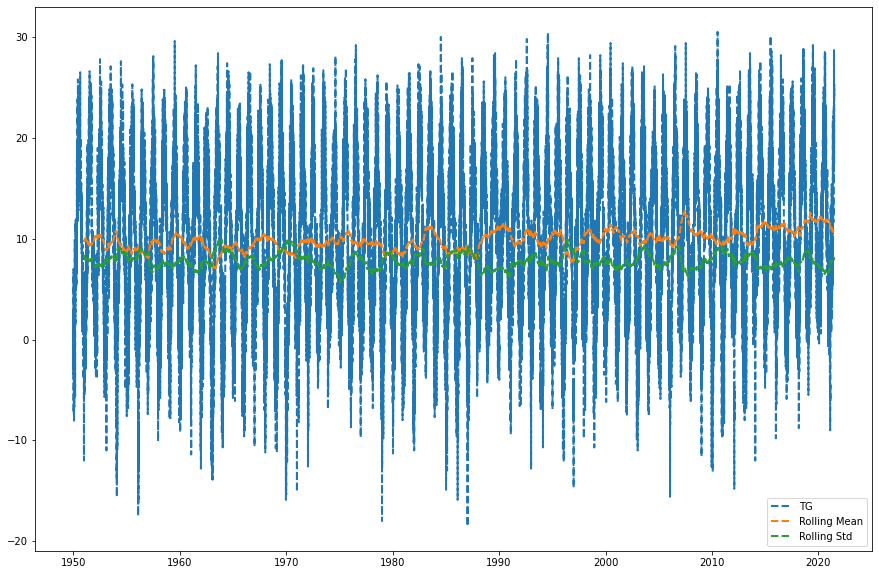

In [22]:
rolling_mean = df_train['TG'].rolling(365).mean()
rolling_std = df_train['TG'].rolling(365).std()
plt.plot(df_train['TG'],label='TG')
plt.plot(rolling_mean, label='Rolling Mean')
plt.plot(rolling_std, label = 'Rolling Std')
plt.legend()

In [74]:
X = df_train['TG']
X1, X2 = X['1950-01-01':'1950-03-31'], X['2020-01-01':'2020-03-31']
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()

print(f'mean1 = {mean1}, mean2 = {mean2}')
print(f'variance1 = {var1}, variance2 = {var2}')

mean1 = 2.4413793103448285, mean2 = 5.592307692307693
variance1 = 29.847337610264635, variance2 = 7.519384615384615



- Based on the above analysis, we conclude that the data is not stationary

In [24]:
df_train['timestep'] = list(range(len(df_train)))

In [25]:
seasonal_dummies = pd.get_dummies(df_train.index.month_name(), drop_first=True).set_index(df_train.index)

In [26]:
df_train = df_train.join(seasonal_dummies)
df_train.head()

,TG,timestep,August,December,February,January,July,June,March,May,November,October,September
DATE,,,,,,,,,,,,,
1950-01-01,-3.5,0,0,0,0,1,0,0,0,0,0,0,0
1950-01-02,1.0,1,0,0,0,1,0,0,0,0,0,0,0
1950-01-03,2.9,2,0,0,0,1,0,0,0,0,0,0,0
1950-01-04,-0.1,3,0,0,0,1,0,0,0,0,0,0,0
1950-01-05,-3.0,4,0,0,0,1,0,0,0,0,0,0,0


In [27]:
m_seas_trend = LinearRegression()

In [28]:
y = df_train['TG']
X=df_train.drop(columns=['TG'])
m_seas_trend.fit(X, y)
df_train['seasonal_trend'] = m_seas_trend.predict(X)

<AxesSubplot:xlabel='DATE'>

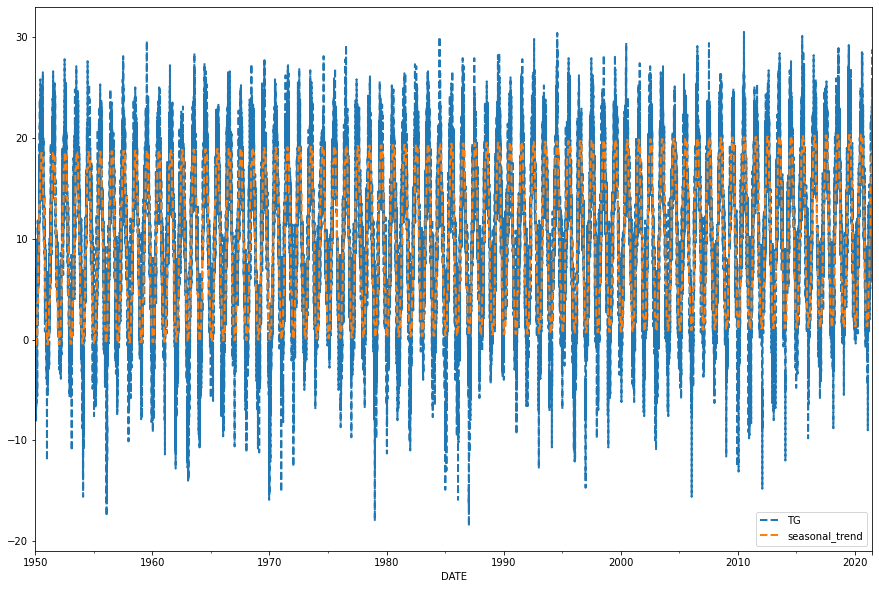

In [29]:
df_train[['TG', 'seasonal_trend']].plot()

In [30]:
df_train['remainder']=df_train['TG']-df_train['seasonal_trend']

<AxesSubplot:xlabel='DATE'>

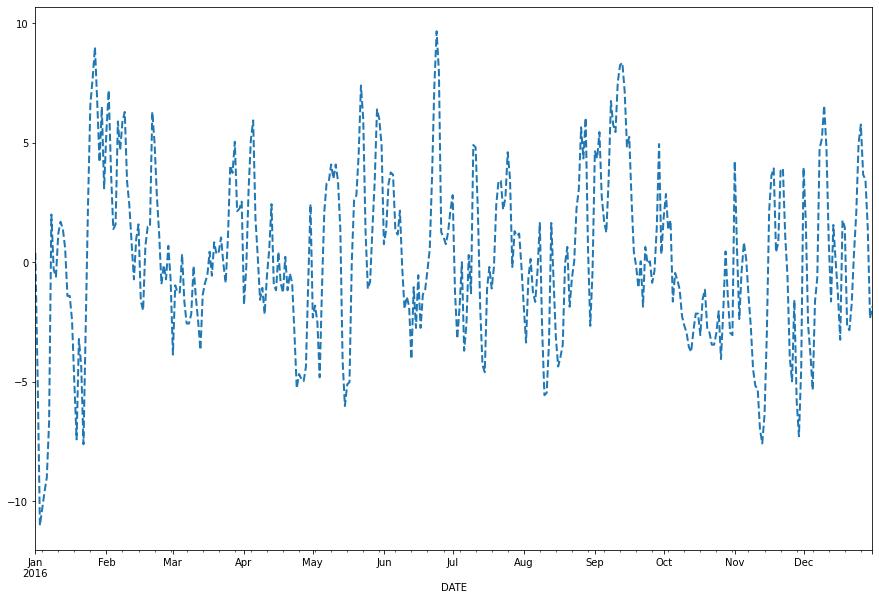

In [31]:
df_train[df_train.index.year==2016]['remainder'].plot()

In [32]:
perform_dickey_fuller_test(df_train['remainder'])

ADF Statistic: -23.122569
p-value: 0.000000
Critical Values:
\t1%: -3.431
\t5%: -2.862
\t10%: -2.567


- One tool to find out which model to use how many lags we should include into our AR Model is to plot the ACF and PACF between different lags of the remainder

Text(0.5, 0, 'lags')

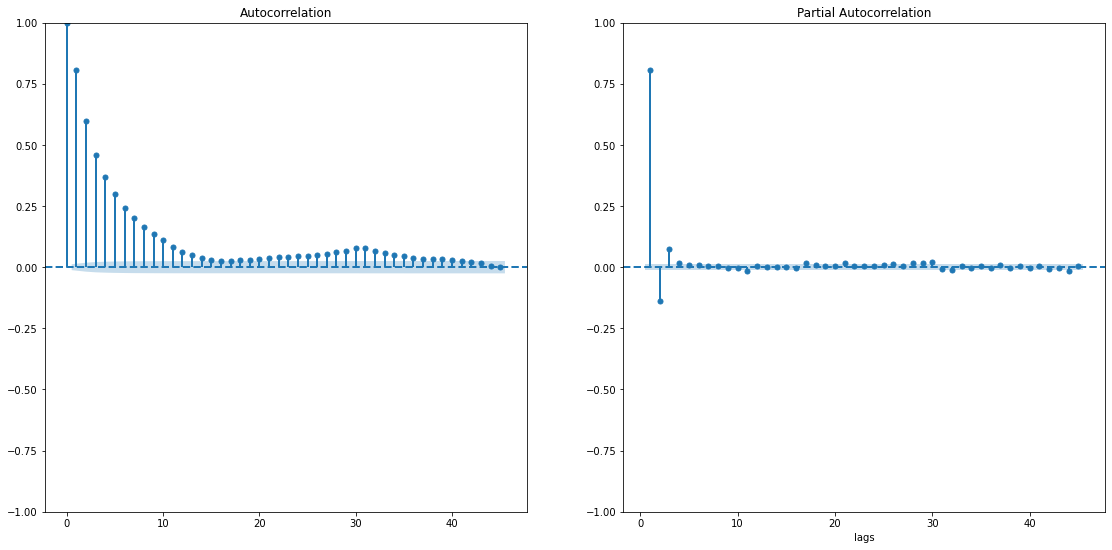

In [33]:
fig,(ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(19, 9)
plot_acf(df_train['remainder'],ax=ax1)
plot_pacf(df_train['remainder'],zero=False, ax=ax2)
plt.xlabel('lags')

- ACF-Plot is clearly showing an exponential and slow decay.
- PACF-Plot also shows exponential decay, but not a slow one. And there is a drop after a certain lag. 
We might conclude that the data is best modelled by an AR(p) process with  p = 3 lags.


**Box-Jenkins-Methodology:**
- This methodology makes a statement about how to choose lags.
- We will choose all lags until the first sharp drop in values. In this case we will have 3 lags. This is the point after which we know the correlation dropped significantly. 



In [34]:
selected_order = ar_select_order(df_train['remainder'], maxlag = 12)

In [35]:
selected_order.ar_lags

[1, 2, 3]

In [36]:
df_train.to_pickle('df_train.pkl')

In [37]:
df_train=pd.read_pickle('df_train.pkl')

In [38]:
#Create  time-lagged input features

In [39]:
df_train['lag1'] = df_train['remainder'].shift(1)
df_train['lag2'] = df_train['remainder'].shift(2)
df_train['lag3'] = df_train['remainder'].shift(3)

In [40]:
df_train.dropna(inplace=True)
df_train.head()

,TG,timestep,August,December,February,January,July,June,March,May,November,October,September,seasonal_trend,remainder,lag1,lag2,lag3
DATE,,,,,,,,,,,,,,,,,,
1950-01-04,-0.1,3,0,0,0,1,0,0,0,0,0,0,0,-0.497169,0.397169,3.397240,1.497311,-3.002618
1950-01-05,-3.0,4,0,0,0,1,0,0,0,0,0,0,0,-0.497098,-2.502902,0.397169,3.397240,1.497311
1950-01-06,2.3,5,0,0,0,1,0,0,0,0,0,0,0,-0.497028,2.797028,-2.502902,0.397169,3.397240
1950-01-07,5.2,6,0,0,0,1,0,0,0,0,0,0,0,-0.496957,5.696957,2.797028,-2.502902,0.397169
1950-01-08,7.0,7,0,0,0,1,0,0,0,0,0,0,0,-0.496886,7.496886,5.696957,2.797028,-2.502902


<AxesSubplot:>

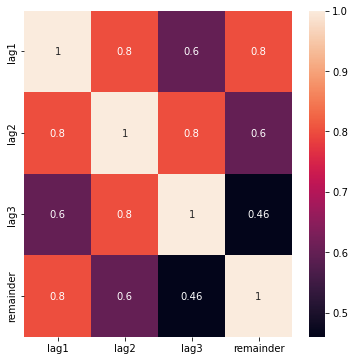

In [41]:
plt.figure(figsize=(6,6))
sns.heatmap(round(df_train[['lag1','lag2','lag3', 'remainder']].corr(), 2), annot=True)

<AxesSubplot:xlabel='lag3', ylabel='remainder'>

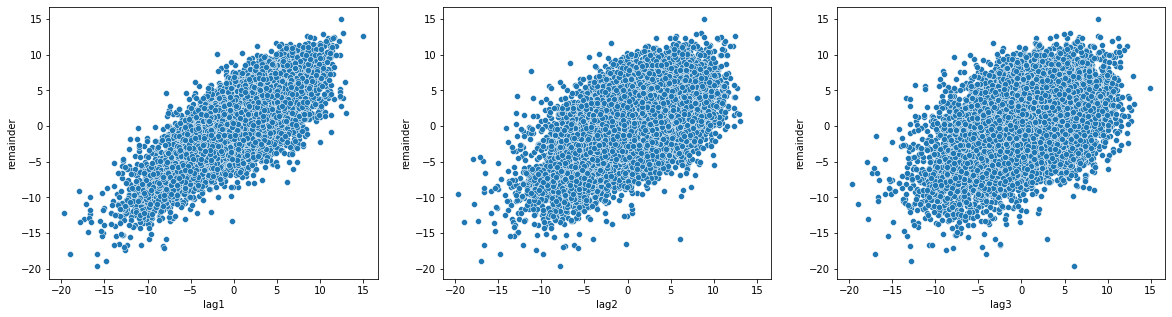

In [42]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(20, 5)
sns.scatterplot(x='lag1', y='remainder', data=df_train,ax=ax1)
sns.scatterplot(x='lag2', y='remainder', data=df_train,ax=ax2)
sns.scatterplot(x='lag3', y='remainder', data=df_train,ax=ax3)


In [43]:
# Define X and y\n",
X = df_train.drop(columns=['TG', 'seasonal_trend', 'remainder'])
y = df_train['TG']

<AxesSubplot:xlabel='DATE'>

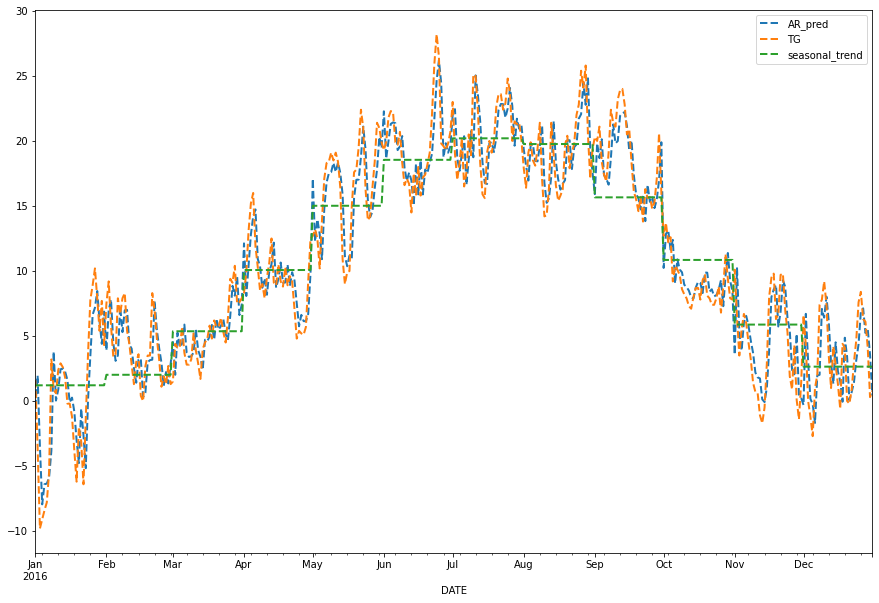

In [44]:
# Train the model
m_AR= LinearRegression()
m_AR.fit(X, y)

# Create a new predictions column for the AR_prediction
df_train['AR_pred'] = m_AR.predict(X)
df_train[df_train.index.year==2016][['AR_pred','TG','seasonal_trend']].plot()

### Cross-validation 
We want to understand how good our model would work on data it has not been trained on. We can get an estimate of that by using cross-validation.
Cross-validation for time series:
- Dividing training data into subsets (folds) - order respective to time is maintained
- in the first iteration, use the first fold to evaluate the second fold
- in the second iteration, use the first and thesecond fold to evaluate the third fold

In [45]:
# Create a TimeSeriesSplit object,
ts_split = TimeSeriesSplit(n_splits=5)
# this is a python generator
time_cv = ts_split.split(X, y) 

In [46]:
# cross validate model and read scores 
time_cv = ts_split.split(X, y)
estimator = LinearRegression()
r_squared_scores = cross_val_score(estimator=estimator, X=X, y=y, cv=time_cv )
print(r_squared_scores)
print(r_squared_scores.mean())

[0.91457125 0.91219012 0.90617742 0.91663044 0.91991351]
0.9138965488543752


In [47]:
## Autoregressive Model - AR(3) on Test data

In [48]:
df_test=pd.read_pickle('df_test.pkl')

In [49]:
# add time step
last_train_timestep = df_train['timestep'].max()
df_test['timestep'] = list(range(last_train_timestep + 1, len(df_test) + last_train_timestep + 1))

In [50]:
# Add encoded month
# we have to apply the same steps we applied to our train data
seasonal_dummies = pd.get_dummies(df_test.index.month_name(), drop_first=True).set_index(df_test.index)

In [51]:
df_test = df_test.join(seasonal_dummies)

In [52]:
#Add trend and seasonality prediction
X_test = df_test.drop('TG', axis=1)
X_test

,timestep,August,December,February,January,July,June,March,May,November,October,September
DATE,,,,,,,,,,,,
2021-06-30,26113,0,0,0,0,0,1,0,0,0,0,0
2021-07-01,26114,0,0,0,0,1,0,0,0,0,0,0
2021-07-02,26115,0,0,0,0,1,0,0,0,0,0,0
2021-07-03,26116,0,0,0,0,1,0,0,0,0,0,0
2021-07-04,26117,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-26,26474,0,0,0,0,0,1,0,0,0,0,0
2022-06-27,26475,0,0,0,0,0,1,0,0,0,0,0
2022-06-28,26476,0,0,0,0,0,1,0,0,0,0,0


In [53]:
#make predictions uning  m_seas_trend model
df_test['seasonal_trend'] = m_seas_trend.predict(X_test)

<AxesSubplot:xlabel='DATE'>

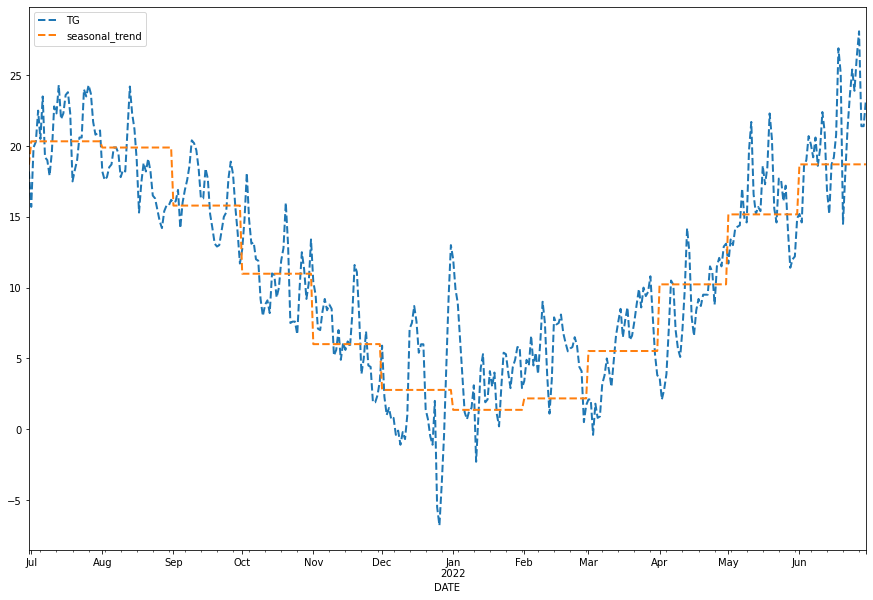

In [54]:
# plot
df_test[['TG', 'seasonal_trend']].plot()

In [55]:
#Calculate remainder and add lags
df_test['remainder'] = df_test['TG'] - df_test['seasonal_trend']
# Create the lagged variable
df_test['lag1'] = df_test['remainder'].shift(1)
df_test['lag2'] = df_test['remainder'].shift(2)
df_test['lag3'] = df_test['remainder'].shift(3)
df_test.head()

,TG,timestep,August,December,February,January,July,June,March,May,November,October,September,seasonal_trend,remainder,lag1,lag2,lag3
DATE,,,,,,,,,,,,,,,,,,
2021-06-30,18.2,26113,0,0,0,0,0,1,0,0,0,0,0,18.678798,-0.478798,NaN,NaN,NaN
2021-07-01,15.7,26114,0,0,0,0,1,0,0,0,0,0,0,20.330662,-4.630662,-0.478798,NaN,NaN
2021-07-02,19.9,26115,0,0,0,0,1,0,0,0,0,0,0,20.330732,-0.430732,-4.630662,-0.478798,NaN
2021-07-03,20.3,26116,0,0,0,0,1,0,0,0,0,0,0,20.330803,-0.030803,-0.430732,-4.630662,-0.478798
2021-07-04,22.5,26117,0,0,0,0,1,0,0,0,0,0,0,20.330874,2.169126,-0.030803,-0.430732,-4.630662


In [56]:
# fill NaN
df_test.loc['2021-06-30', 'lag1'] = df_train.loc['2021-06-29', 'remainder']
df_test.loc['2021-06-30', 'lag2'] = df_train.loc['2021-06-28', 'remainder']
df_test.loc['2021-06-30', 'lag3'] = df_train.loc['2021-06-27', 'remainder']

df_test.loc['2021-07-01', 'lag3'] = df_train.loc['2021-06-28', 'remainder']

df_test.loc['2021-07-01', 'lag2'] = df_train.loc['2021-06-29', 'remainder']

df_test.loc['2021-07-02', 'lag3'] = df_train.loc['2021-06-29', 'remainder']
df_test.head()

,TG,timestep,August,December,February,January,July,June,March,May,November,October,September,seasonal_trend,remainder,lag1,lag2,lag3
DATE,,,,,,,,,,,,,,,,,,
2021-06-30,18.2,26113,0,0,0,0,0,1,0,0,0,0,0,18.678798,-0.478798,5.421273,6.621343,3.421414
2021-07-01,15.7,26114,0,0,0,0,1,0,0,0,0,0,0,20.330662,-4.630662,-0.478798,5.421273,6.621343
2021-07-02,19.9,26115,0,0,0,0,1,0,0,0,0,0,0,20.330732,-0.430732,-4.630662,-0.478798,5.421273
2021-07-03,20.3,26116,0,0,0,0,1,0,0,0,0,0,0,20.330803,-0.030803,-0.430732,-4.630662,-0.478798
2021-07-04,22.5,26117,0,0,0,0,1,0,0,0,0,0,0,20.330874,2.169126,-0.030803,-0.430732,-4.630662


In [57]:
# make AG model predictions
X_test = df_test.drop(['TG', 'seasonal_trend', 'remainder'], axis=1)
X_test

,timestep,August,December,February,January,July,June,March,May,November,October,September,lag1,lag2,lag3
DATE,,,,,,,,,,,,,,,
2021-06-30,26113,0,0,0,0,0,1,0,0,0,0,0,5.421273,6.621343,3.421414
2021-07-01,26114,0,0,0,0,1,0,0,0,0,0,0,-0.478798,5.421273,6.621343
2021-07-02,26115,0,0,0,0,1,0,0,0,0,0,0,-4.630662,-0.478798,5.421273
2021-07-03,26116,0,0,0,0,1,0,0,0,0,0,0,-0.430732,-4.630662,-0.478798
2021-07-04,26117,0,0,0,0,1,0,0,0,0,0,0,-0.030803,-0.430732,-4.630662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-26,26474,0,0,0,0,0,1,0,0,0,0,0,5.195706,6.695777,4.895848
2022-06-27,26475,0,0,0,0,0,1,0,0,0,0,0,7.595636,5.195706,6.695777
2022-06-28,26476,0,0,0,0,0,1,0,0,0,0,0,9.395565,7.595636,5.195706


In [58]:
# Create the predictions
df_test['AR_pred'] = m_AR.predict(X_test)
df_test.head()

,TG,timestep,August,December,February,January,July,June,March,May,November,October,September,seasonal_trend,remainder,lag1,lag2,lag3,AR_pred
DATE,,,,,,,,,,,,,,,,,,,
2021-06-30,18.2,26113,0,0,0,0,0,1,0,0,0,0,0,18.678798,-0.478798,5.421273,6.621343,3.421414,22.558507
2021-07-01,15.7,26114,0,0,0,0,1,0,0,0,0,0,0,20.330662,-4.630662,-0.478798,5.421273,6.621343,19.258242
2021-07-02,19.9,26115,0,0,0,0,1,0,0,0,0,0,0,20.330732,-0.430732,-4.630662,-0.478798,5.421273,16.545056
2021-07-03,20.3,26116,0,0,0,0,1,0,0,0,0,0,0,20.330803,-0.030803,-0.430732,-4.630662,-0.478798,20.862373
2021-07-04,22.5,26117,0,0,0,0,1,0,0,0,0,0,0,20.330874,2.169126,-0.030803,-0.430732,-4.630662,20.054956


<AxesSubplot:xlabel='DATE'>

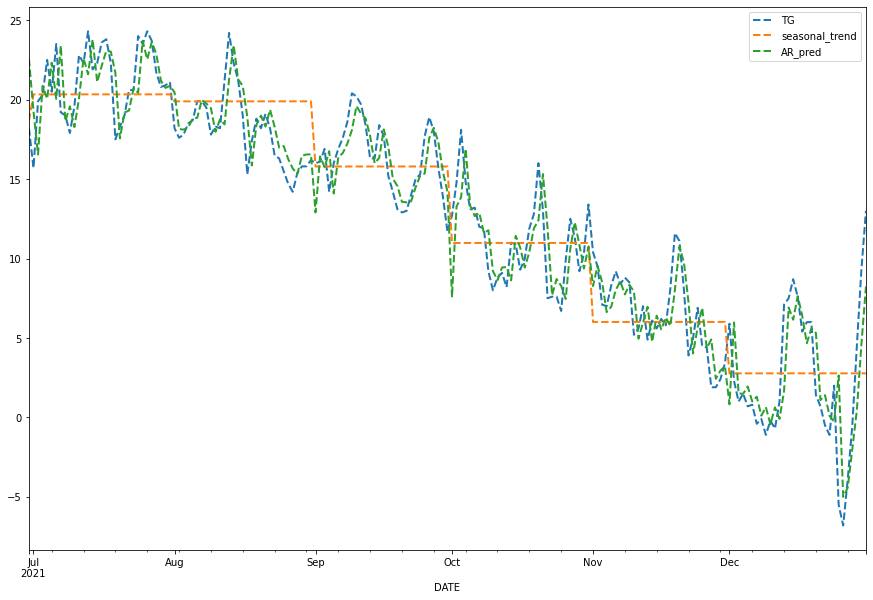

In [76]:
df_test[df_test.index.year==2021][['TG', 'seasonal_trend','AR_pred']].plot()

In [60]:
df_train=df_train.dropna()

In [61]:
### Evaluation
# let's check R squared score
print("R2 score Trend+Seasonality Model :",r2_score(df_test['TG'], df_test['seasonal_trend']))
print("R2 score Autoregressive Model    :",r2_score(df_test['TG'], df_test['AR_pred']))
print("MSE Trend+Seasonality Model :", mean_squared_error(df_test['TG'], df_test['seasonal_trend']))
print("MSE Autoregressive Model    :", mean_squared_error(df_test['TG'], df_test['AR_pred']))

R2 score Trend+Seasonality Model : 0.7931552101410824
R2 score Autoregressive Model    : 0.916524157875547
MSE Trend+Seasonality Model : 10.52159714630322
MSE Autoregressive Model    : 4.2461750324045555


In [62]:
## Retrain the model on the whole data and generate short term predictions
# join test and train data together
df_combined = df_train.append(df_test)
df_combined.tail()

,TG,timestep,August,December,February,January,July,June,March,May,November,October,September,seasonal_trend,remainder,lag1,lag2,lag3,AR_pred
DATE,,,,,,,,,,,,,,,,,,,
2022-06-26,26.3,26474,0,0,0,0,0,1,0,0,0,0,0,18.704364,7.595636,5.195706,6.695777,4.895848,22.468666
2022-06-27,28.1,26475,0,0,0,0,0,1,0,0,0,0,0,18.704435,9.395565,7.595636,5.195706,6.695777,25.137327
2022-06-28,21.4,26476,0,0,0,0,0,1,0,0,0,0,0,18.704506,2.695494,9.395565,7.595636,5.195706,26.196949
2022-06-29,21.4,26477,0,0,0,0,0,1,0,0,0,0,0,18.704577,2.695423,2.695494,9.395565,7.595636,19.791398
2022-06-30,23.3,26478,0,0,0,0,0,1,0,0,0,0,0,18.704648,4.595352,2.695423,2.695494,9.395565,21.314080


In [63]:
#df_combined.to_pickle('combined.pkl')
#df_train.to_pickle('train.pkl')
#df_test.to_pickle('test.pkl')

In [64]:
#df_combined = pd.read_pickle('df_combined.pkl')

In [77]:
# Re-train the model on the whole dataset
X_combined = df_combined.drop(columns=['TG', 'seasonal_trend', 'remainder', 'AR_pred'])
y_combined = df_combined['TG']
m_AR_combined = LinearRegression()
m_AR_combined.fit(X_combined, y_combined)
X_combined

,timestep,August,December,February,January,July,June,March,May,November,October,September,lag1,lag2,lag3
DATE,,,,,,,,,,,,,,,
1950-01-04,3,0,0,0,1,0,0,0,0,0,0,0,3.397240,1.497311,-3.002618
1950-01-05,4,0,0,0,1,0,0,0,0,0,0,0,0.397169,3.397240,1.497311
1950-01-06,5,0,0,0,1,0,0,0,0,0,0,0,-2.502902,0.397169,3.397240
1950-01-07,6,0,0,0,1,0,0,0,0,0,0,0,2.797028,-2.502902,0.397169
1950-01-08,7,0,0,0,1,0,0,0,0,0,0,0,5.696957,2.797028,-2.502902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-26,26474,0,0,0,0,0,1,0,0,0,0,0,5.195706,6.695777,4.895848
2022-06-27,26475,0,0,0,0,0,1,0,0,0,0,0,7.595636,5.195706,6.695777
2022-06-28,26476,0,0,0,0,0,1,0,0,0,0,0,9.395565,7.595636,5.195706


In [66]:
## Generate prediction for a future time
#df_combined.index.max()

#generate features for the time point 2022-07-01
X_future = []
timestep = df_combined['timestep'].max() + 1
months = [0]*4 + [1] + [0]*6  #dummy code for July
lag1 = df_combined.loc['2022-06-30', 'remainder'] 
lag2 = df_combined.loc['2022-06-29', 'remainder'] 
lag3 = df_combined.loc['2022-06-28', 'remainder'] 
print(timestep, months, lag1,lag2,lag3)

26479 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0] 4.595352373649899 2.6954231938732818 2.6954940140966634


In [67]:
X_future.append(timestep)
X_future.extend(months)
X_future.append(lag1)
X_future.append(lag2)
X_future.append(lag3)
print(X_future)

[26479, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 4.595352373649899, 2.6954231938732818, 2.6954940140966634]


In [68]:
X_future = pd.DataFrame([X_future])
X_future.columns = X_combined.columns
X_future

,timestep,August,December,February,January,July,June,March,May,November,October,September,lag1,lag2,lag3
0,26479,0,0,0,0,1,0,0,0,0,0,0,4.595352,2.695423,2.695494


In [69]:
print("Prediction for 2022-07-01 is {}".format(m_AR_combined.predict(X_future)[0]))

Prediction for 2022-07-01 is 24.268416783802376
